# Final Model and  Diagnostics
### Added Variables 
<ul>
    <li> <b>Identifier Varialbes </b></li>
        <ul>
            <li>Variables that expand on string categories in the inital date set</li>
            <li>Applicable Columns in the raw data: trial_country and day_of_week </li>
            <li>Example for the variable us: <pre><code>if trial_country == 'United States': us = 1 else: us = 0 </code></pre>
            </li>
        </ul>
    <li><b>Cohort Variables </b>
        <ul>
        <li>Variables that indicate the prior statistics for the cohort the user is a part of</li>
         <li>cohort_numTrials : Number of rows in cohort </li>
         <li>cohort_day0_yield : Day 0 yield                      </li>
         <li>cohort_ytd : Percent yield calculated at current date</li>
        </ul>
</ul>

### Psuedo code for estimate function 
    load in pandas df with all indentifier variables, cohort variables are added at runtime 
    def estimate_cohort_yeild (start date, current date):
        - filter df for users who have lower sublag then we are looking for 
        - imediately split df into: 
            1) the training data (all data for not start date)
            2) the test data (data for start date)
        - anotate the loaded df with the cohort vars aplicable at (current date - start date)
        - break test and train sets into np arrays so they can be fed into sklearn algs 
        - train model (probably simple linear model) on training -> yes im doing this like this 
        - predict the number of subscribers remaining for the cohort
            - sum the vector of probability subscribe generated by the learned model 
        - query test data to see how many subsribers we already have call this actual_subs
        - return (predicted+actual_subs) / (number of users in cohort)

In [223]:
import pandas as pd 
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pyplt
import math
import time
from sklearn import linear_model
%matplotlib inline  
plt.style.use('ggplot')
pdf=pd.read_csv('Anotated_Strategy_Data_Set.csv',parse_dates=['trial_date','subscription_date','trial_dateTime','sub_dateTime'], infer_datetime_format=True)
pdf['subLag']=pdf['sub_dateTime']-pdf['trial_dateTime']

#Function: anotate_cohort_vars
#       This function adds the cohort data to the df via a join 
#
#                              Input
#        ----------------------------------------------------------
#       | name |    Type        |          Description            |
#       |-------------------------------------------------------- |
#       | diff | np.timedelta64 | how days into the trial are we  |
#       | df   | pd.dataframe   | dataframe with indicators added |  
#        ----------------------------------------------------------
#
#                              Output
#        ----------------------------------------------------------
#       | name |    Type        |          Description            |
#       |-------------------------------------------------------- |
#       | df   | pd.dataframe   | dataframe with cohort data added|  
#        ----------------------------------------------------------

def anotate_cohort_vars (diff,df):
    cScore={}
    for row in df.trial_date.unique():
        sdf=df[df.trial_date==row]
        # calculate day0 yield 
        if diff >= np.timedelta64(1, 'D'):
            i1=sdf[(sdf.subLag != np.timedelta64(0, 's')) & (sdf.subLag < np.timedelta64(1, 'D')) ].id.count()
        else: 
            i1=0
        # calculate yield to date 
        i2=sdf[(sdf.subLag != np.timedelta64(0, 's')) & (sdf.subLag < diff) ].id.count()
        # etc etc 
        c=sdf.id.count()
        cScore[row]=(row,c,i1/c,i2/c)
    #print (cScore[np.datetime64('2013-05-01T00:00:00.000000000')])
    toAdd=pd.DataFrame.from_dict(cScore,orient='index')
    toAdd.columns = ['trial_date','cohort_numTrials', 'cohort_day0_yield','cohort_ytd']
    df=df.join(toAdd, on='trial_date',rsuffix='throwaway')
    df.drop(['trial_datethrowaway','Unnamed: 0'],inplace=True,axis=1)
    return df

#Function: estimate_yield
#          This function estimates the yield percentage for a cohort starting at start_date.  Each time the mehtod is 
#          called it generates a model to estimate the probability a user subscribes.  The method is trained on all 
#          data in the data set holding out the day we estimating to avoid bias.  Additionally it filters out all rows
#          that have subscribed within (start_date-current_date) time in training and test sets so the model will 
#          implicitly account for the time decay feature. It uses data up to current_date to generate the 
#          cohort statistics.
#                                        Input
#        ----------------------------------------------------------------------
#       | name         |   Type  |          Description                        |
#       |--------------------------------------------------------------------- |
#       | start_date   | string  | YYYY-MM-DD string for the cohort start date |
#       | current_date | string  | YYYY-MM-DD string for the current date      | 
#       | verbose      | boolean | Flag for if you want diagnostics printed    | 
#        -----------------------------------------------------------------------
#
#                              Output
#        ----------------------------------------------------------
#       | name      | Type   |          Description               |
#       |-------------------------------------------------------- |
#       | Estimate | float   | Estimated cohort yield             |  
#        ----------------------------------------------------------
def estimate_yield(start_date, current_date,verbose):
    #load data
    adf=pd.read_csv('Anotated_Strategy_Data_Set.csv',parse_dates=['trial_date','subscription_date','trial_dateTime','sub_dateTime'], infer_datetime_format=True)
    adf['subLag']=adf['sub_dateTime']-adf['trial_dateTime']
    startDate=np.datetime64(start_date)
    currentDate=np.datetime64(current_date)
    delta=currentDate-startDate
    if verbose: print (str(delta) + ' out estimate')
    df=anotate_cohort_vars(delta,adf)
    df=df[(df.sub_hour_start.isnull()) | (df.subLag >= delta)]
    variables = ['trial_hour','us','uk','can','aus','mon','tueWed','sunSat','thr','cohort_numTrials','cohort_day0_yield','cohort_ytd']
    test =df[df.trial_date==start_date]
    train=df[df.trial_date!=start_date]
    train_x=train[variables].as_matrix()
    train_y=train['sub_label'].as_matrix()
    test_x=test[variables].as_matrix()
    test_y=test['sub_label'].as_matrix()
    if verbose: print('Test dims: '+ str(test.shape))
    if verbose: print('Train dims: '+ str(train.shape))
    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(train_x, train_y)
    #generate the diagnostics and store them in the respective lists 
    p=sum(regr.predict(test_x))
    if verbose: print('Predicted Remaining: '+ str(p))
    std=adf[(adf.subLag<delta) & (adf.trial_date==start_date)].id.count()
    a=test[test.sub_label ==1].id.count()
    if verbose: print('Actual Remaining: '+str(a))
    if verbose: print('Number of subscribers in the cohort to date: '+ str(std))
    r=1-abs(p-a)/a 
    if verbose: print('Remaining Subs Prediction Accuracy: '+str(r))  
    if verbose: print('Total Estimate: '+str(std+p))
    actual=adf[(adf.sub_label==1) & (adf.trial_date==start_date)].id.count()
    count=adf[adf.trial_date==start_date].id.count()
    lb=(std+(p*(1-abs(p-a)/a)))/count
    ub=(std+(p*(1+abs(p-a)/a)))/count
    if verbose: print('Correct answer: '+ str(actual))
    if verbose: print('Total Accuracy: ' + str(1-abs((std+p)-actual)/actual))
    if verbose: print ('Yeild Estimate: ' + str((std+p)/count))
    return (std+p)/count

In [224]:
estimate_yield('2013-05-02','2013-05-02',True)

0 days out estimate
Test dims: (2538, 23)
Train dims: (72353, 23)
Predicted Remaining: 550.386104177
Actual Remaining: 549
Number of subscribers in the cohort to date: 0
Remaining Subs Prediction Accuracy: 0.997475220078
Total Estimate: 550.386104177
Correct answer: 549
Total Accuracy: 0.997475220078
Yeild Estimate: 0.216858197075


0.21685819707536044

In [225]:
estimate_yield('2013-05-02','2013-05-04',True)

2 days out estimate
Test dims: (2376, 23)
Train dims: (67604, 23)
Predicted Remaining: 370.940530573
Actual Remaining: 387
Number of subscribers in the cohort to date: 162
Remaining Subs Prediction Accuracy: 0.95850266298
Total Estimate: 532.940530573
Correct answer: 549
Total Accuracy: 0.970747778822
Yeild Estimate: 0.20998444861


0.20998444861038376

In [226]:
estimate_yield('2013-05-02','2013-05-19',False)

0.21718524804413863

In [227]:
estimate_yield('2013-05-02','2014-08-19',True)

474 days out estimate
Test dims: (1989, 23)
Train dims: (57331, 23)
Predicted Remaining: 0.0
Actual Remaining: 0
Number of subscribers in the cohort to date: 549
Remaining Subs Prediction Accuracy: nan
Total Estimate: 549.0
Correct answer: 549
Total Accuracy: 1.0
Yeild Estimate: 0.216312056738


C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:104: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:109: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:110: RuntimeWarning: invalid value encountered in double_scalars


0.21631205673758866

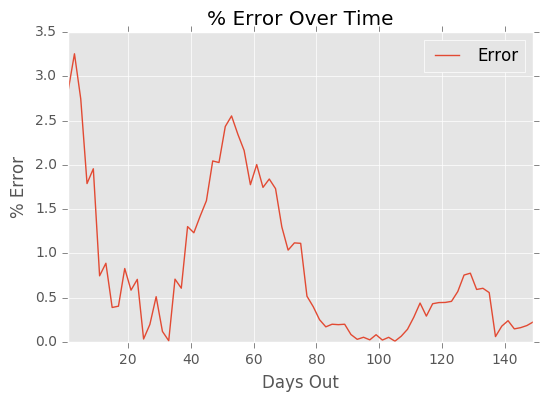

In [228]:
est=[]
mDate=150
for i in range (1,mDate,2):
    sDate='2013-05-02'
    tDate=str(np.datetime64(sDate)+np.timedelta64(i, 'D'))
    actual=pdf[(pdf.sub_label==1) & (pdf.trial_date==sDate)].id.count()
    count=pdf[pdf.trial_date==sDate].id.count()
    ratio=actual/count
    estimate=estimate_yield(sDate,tDate,False)
    est.append([i,abs(estimate-ratio)/ratio*100])

tp=pd.DataFrame(est,columns=['Days Out','Error'])
tp.plot(x='Days Out', y='Error')
pyplt.ylabel('% Error')
pyplt.title('% Error Over Time')
pyplt.legend(['Error'],loc='upper right')

C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:104: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:109: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:110: RuntimeWarning: divide by zero encountered in double_scalars


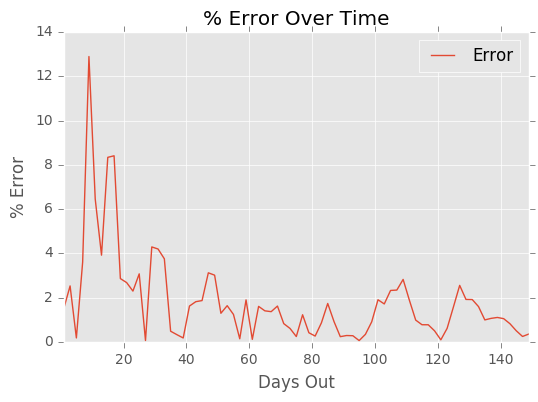

In [229]:
est=[]
mDate=150
for i in range (1,mDate,2):
    sDate='2013-05-20'
    tDate=str(np.datetime64(sDate)+np.timedelta64(i, 'D'))
    actual=pdf[(pdf.sub_label==1) & (pdf.trial_date==sDate)].id.count()
    count=pdf[pdf.trial_date==sDate].id.count()
    ratio=actual/count
    estimate=estimate_yield(sDate,tDate,False)
    est.append([i,abs(estimate-ratio)/ratio*100])

tp=pd.DataFrame(est,columns=['Days Out','Error'])
tp.plot(x='Days Out', y='Error')
pyplt.ylabel('% Error')
pyplt.title('% Error Over Time')
pyplt.legend(['Error'],loc='upper right')

C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:104: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:109: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:110: RuntimeWarning: divide by zero encountered in double_scalars


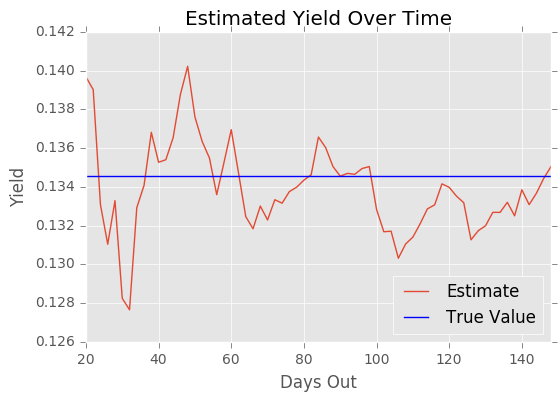

In [235]:
est=[]
mDate=150
startDay=20
for i in range (startDay,mDate,2):
    sDate='2013-05-'+str(startDay)
    tDate=str(np.datetime64(sDate)+np.timedelta64(i, 'D'))
    est.append([i,(estimate_yield(sDate,tDate,False))])

actual=pdf[(pdf.sub_label==1) & (pdf.trial_date==sDate)].id.count()
count=pdf[pdf.trial_date==sDate].id.count()
ratio=actual/count
tp=pd.DataFrame(est,columns=['Days Out','Estimate'])
tp.plot(x='Days Out', y='Estimate')
pyplt.axhline(y=ratio)
pyplt.ylabel('Yield')
pyplt.title('Estimated Yield Over Time')
pyplt.legend(['Estimate','True Value'],loc='lower right')

C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:104: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:109: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:110: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:104: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:109: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:110: RuntimeWarning: invalid value encountered in double_scalars


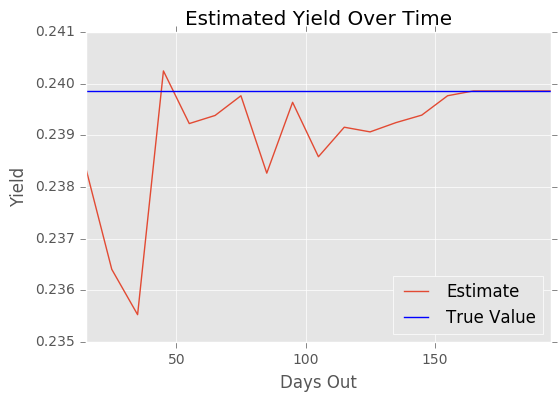

In [241]:
est=[]
mDate=200
startDay=15
for i in range (startDay,mDate,10):
    sDate='2013-05-'+str(startDay)
    tDate=str(np.datetime64(sDate)+np.timedelta64(i, 'D'))
    est.append([i,(estimate_yield(sDate,tDate,False))])

actual=pdf[(pdf.sub_label==1) & (pdf.trial_date==sDate)].id.count()
count=pdf[pdf.trial_date==sDate].id.count()
ratio=actual/count
tp=pd.DataFrame(est,columns=['Days Out','Estimate'])
tp.plot(x='Days Out', y='Estimate')
pyplt.axhline(y=ratio)
pyplt.ylabel('Yield')
pyplt.title('Estimated Yield Over Time')
pyplt.legend(['Estimate','True Value'],loc='lower right')

C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:104: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:109: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:110: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:104: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:109: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:110: RuntimeWarning: invalid value encountered in double_scalars


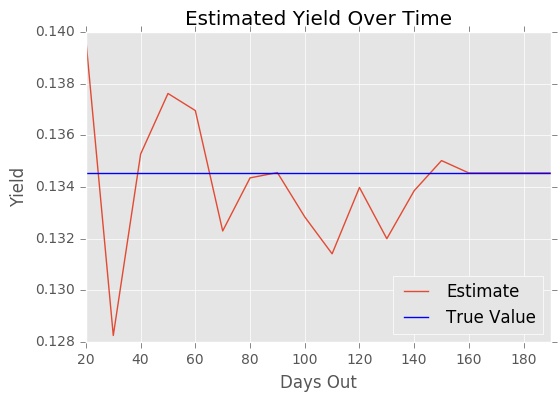

In [244]:
est=[]
mDate=200
startDay=20
for i in range (startDay,mDate,10):
    sDate='2013-05-'+str(startDay)
    tDate=str(np.datetime64(sDate)+np.timedelta64(i, 'D'))
    est.append([i,(estimate_yield(sDate,tDate,False))])
actual=pdf[(pdf.sub_label==1) & (pdf.trial_date==sDate)].id.count()
count=pdf[pdf.trial_date==sDate].id.count()
ratio=actual/count
tp=pd.DataFrame(est,columns=['Days Out','Estimate'])
tp.plot(x='Days Out', y='Estimate')
pyplt.axhline(y=ratio)
pyplt.ylabel('Yield')
pyplt.title('Estimated Yield Over Time')
pyplt.legend(['Estimate','True Value'],loc='lower right')

C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:104: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:109: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:110: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:104: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:109: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Willie\Anaconda\lib\site-packages\ipykernel\__main__.py:110: RuntimeWarning: invalid value encountered in double_scalars


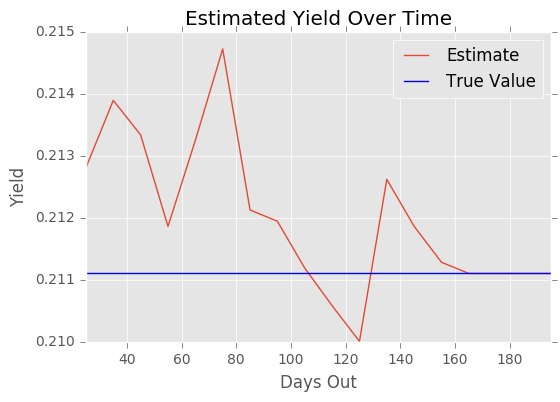

In [238]:
est=[]
mDate=200
startDay=25
for i in range (startDay,mDate,10):
    sDate='2013-05-'+str(startDay)
    tDate=str(np.datetime64(sDate)+np.timedelta64(i, 'D'))
    est.append([i,(estimate_yield(sDate,tDate,False))])

actual=pdf[(pdf.sub_label==1) & (pdf.trial_date==sDate)].id.count()
count=pdf[pdf.trial_date==sDate].id.count()
ratio=actual/count
tp=pd.DataFrame(est,columns=['Days Out','Estimate'])
tp.plot(x='Days Out', y='Estimate')
pyplt.axhline(y=ratio)
pyplt.ylabel('Yield')
pyplt.title('Estimated Yield Over Time')
pyplt.legend(['Estimate','True Value'],loc='upper right')

C:\Users\Willie\Anaconda\lib\site-packages\matplotlib\legend.py:325: UserWarning: Unrecognized location "middle right". Falling back on "best"; valid locations are
	center left
	center right
	center
	upper center
	upper right
	best
	upper left
	lower right
	right
	lower center
	lower left

  six.iterkeys(self.codes))))


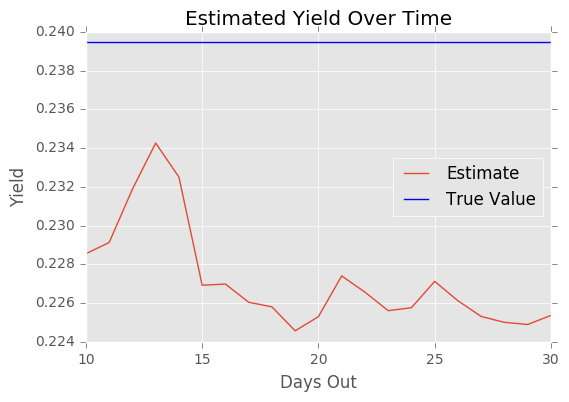

In [239]:
est=[]
mDate=31
startDay=10
for i in range (startDay,mDate,1):
    sDate='2013-05-'+str(startDay)
    tDate=str(np.datetime64(sDate)+np.timedelta64(i, 'D'))
    est.append([i,(estimate_yield(sDate,tDate,False))])

actual=pdf[(pdf.sub_label==1) & (pdf.trial_date==sDate)].id.count()
count=pdf[pdf.trial_date==sDate].id.count()
ratio=actual/count
tp=pd.DataFrame(est,columns=['Days Out','Estimate'])
tp.plot(x='Days Out', y='Estimate')
pyplt.axhline(y=ratio)
pyplt.ylabel('Yield')
pyplt.title('Estimated Yield Over Time')
pyplt.legend(['Estimate','True Value'],loc='middle right')

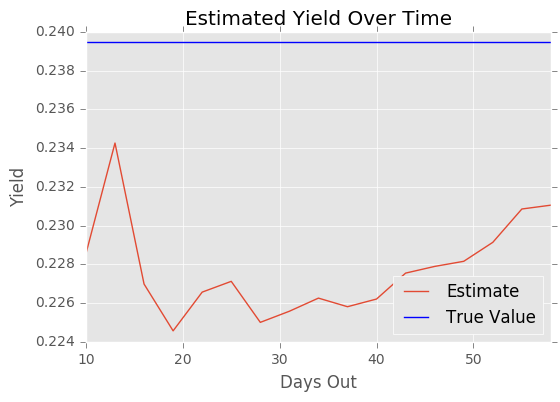

In [240]:
est=[]
mDate=60
startDay=10
for i in range (startDay,mDate,3):
    sDate='2013-05-'+str(startDay)
    tDate=str(np.datetime64(sDate)+np.timedelta64(i, 'D'))
    est.append([i,(estimate_yield(sDate,tDate,False))])

actual=pdf[(pdf.sub_label==1) & (pdf.trial_date==sDate)].id.count()
count=pdf[pdf.trial_date==sDate].id.count()
ratio=actual/count
tp=pd.DataFrame(est,columns=['Days Out','Estimate'])
tp.plot(x='Days Out', y='Estimate')
pyplt.axhline(y=ratio)
pyplt.ylabel('Yield')
pyplt.title('Estimated Yield Over Time')
pyplt.legend(['Estimate','True Value'],loc='lower right')

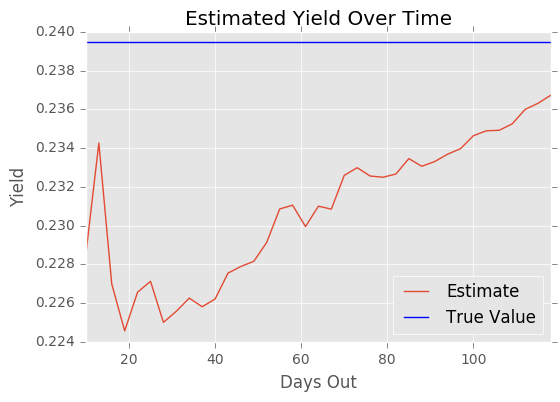

In [242]:
est=[]
mDate=120
startDay=10
for i in range (startDay,mDate,3):
    sDate='2013-05-'+str(startDay)
    tDate=str(np.datetime64(sDate)+np.timedelta64(i, 'D'))
    est.append([i,(estimate_yield(sDate,tDate,False))])

actual=pdf[(pdf.sub_label==1) & (pdf.trial_date==sDate)].id.count()
count=pdf[pdf.trial_date==sDate].id.count()
ratio=actual/count
tp=pd.DataFrame(est,columns=['Days Out','Estimate'])
tp.plot(x='Days Out', y='Estimate')
pyplt.axhline(y=ratio)
pyplt.ylabel('Yield')
pyplt.title('Estimated Yield Over Time')
pyplt.legend(['Estimate','True Value'],loc='lower right')

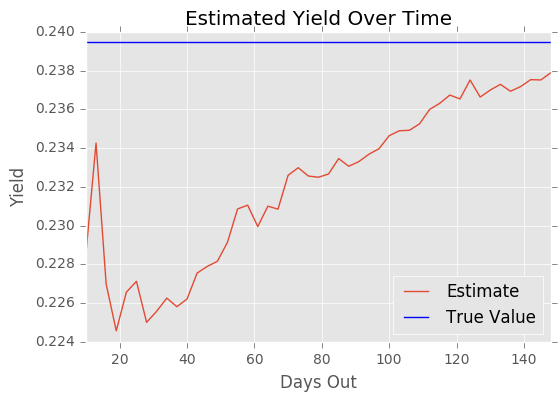

In [243]:
est=[]
mDate=150
startDay=10
for i in range (startDay,mDate,3):
    sDate='2013-05-'+str(startDay)
    tDate=str(np.datetime64(sDate)+np.timedelta64(i, 'D'))
    est.append([i,(estimate_yield(sDate,tDate,False))])

actual=pdf[(pdf.sub_label==1) & (pdf.trial_date==sDate)].id.count()
count=pdf[pdf.trial_date==sDate].id.count()
ratio=actual/count
tp=pd.DataFrame(est,columns=['Days Out','Estimate'])
tp.plot(x='Days Out', y='Estimate')
pyplt.axhline(y=ratio)
pyplt.ylabel('Yield')
pyplt.title('Estimated Yield Over Time')
pyplt.legend(['Estimate','True Value'],loc='lower right')